**Mounting the Google Drive to use data**  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing all the libraries**

In [2]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib 
import matplotlib.pyplot as plt

**To check whether using cpu or gpu**

In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cuda


**Data PreProcessing**

In [5]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((220,220)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [6]:
#Path for training and testing directory

train_path='/content/drive/MyDrive/Data Set/train'
validation_path='/content/drive/MyDrive/Data Set/validation'
test_path='/content/drive/MyDrive/Data Set/test'

#Dataloader

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=16, shuffle=True
)

validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=16, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=16, shuffle=True
)

**Visualizing few images from training set**

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


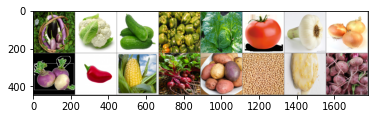

In [7]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [8]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [9]:
print(classes)

['beetroot', 'bell pepper', 'broccli', 'cabbage', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lemon', 'lettuce', 'onion', 'peas', 'potato', 'raddish', 'soya beans', 'spinach', 'tomato', 'turnip']


**Designing the cnn model**

In [10]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=23):
        super(ConvNet,self).__init__() 
        #inputshape(32,3,220,220)
        self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=7,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=8)
        self.relu1=nn.LeakyReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=7,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=7,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=32)
        self.relu2=nn.LeakyReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2)
        #shape(32,32,50,50)
        self.fc1=nn.Linear(in_features=32*50*50,out_features=4000)
        self.fc2=nn.Linear(in_features=4000,out_features=4000)
        self.fc3=nn.Linear(in_features=4000,out_features=num_classes)
        self.softmax=nn.Softmax(dim=1)
        
        #feed forward function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)
        output=self.conv2(output)
        output=self.conv3(output)
        output=self.bn2(output)
        output=self.relu2(output)
        output=self.pool2(output)
        #above output will be in matrix form with shape(32,32,50,50)
        output=output.view(-1,32*50*50)
        output=self.fc1(output)
        output=self.fc2(output)
        output=self.fc3(output)
        output=self.softmax(output)
            
        return output


In [11]:
model=ConvNet(num_classes=23).to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=4000, bias=True)
  (fc2): Linear(in_features=4000, out_features=4000, bias=True)
  (fc3): Linear(in_features=4000, out_features=23, bias=True)
  (softmax): Softmax(dim=1)
)


In [12]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [13]:
num_epochs=10

**calculating the train,test and validation images**

In [14]:
#calculating the size of training and validation and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
validation_count=len(glob.glob(validation_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [15]:
print(train_count,validation_count,test_count)

1577 205 422


**Training the model and Saving the best model**

In [16]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #training on training dataset
    
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    tr_accuracy = []
    train_losses = []
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        train_losses.append(train_loss.item())
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        tr_accuracy.append(train_accuracy)
        
    train_accuracy=train_accuracy/train_count
    #tr_accuracy.append(train_accuracy)
    train_loss=train_loss/train_count
    #train_losses.append(train_loss.item())

    
    
    # Evaluation on validation dataset
    
    model.eval()
    validation_accuracy=0.0
    validation_loss=0.0
    val_accuracy = []
    val_losses = []

    for i, (images,labels) in enumerate(validation_loader):
        if torch.cuda.is_available():
           images=Variable(images.cuda())
           labels=Variable(labels.cuda())
            
           
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        validation_loss+= loss.cpu().data*images.size(0)
        val_losses.append(validation_loss.item())
        _,prediction=torch.max(outputs.data,1)
        validation_accuracy+=int(torch.sum(prediction==labels.data))
        val_accuracy.append(validation_accuracy)
    
    validation_accuracy=validation_accuracy/validation_count
    validation_loss=validation_loss/validation_count

    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' validation Loss: '+str(validation_loss)+' validation Accuracy: '+str(validation_accuracy))
    
    #Save the best model
    model_save_name='best_checkpoint.model'
    path=F"/content/drive/MyDrive/Colab Notebooks/{model_save_name}"
    if train_accuracy>best_accuracy:
        torch.save(model.state_dict(),path)
        best_accuracy=train_accuracy
  


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 0 Train Loss: tensor(3.5568) Train Accuracy: 0.05199746353836398 validation Loss: tensor(3.5607) validation Accuracy: 0.05365853658536585
Epoch: 1 Train Loss: tensor(3.5575) Train Accuracy: 0.05072923272035511 validation Loss: tensor(3.5607) validation Accuracy: 0.05365853658536585
Epoch: 2 Train Loss: tensor(3.5550) Train Accuracy: 0.05326569435637286 validation Loss: tensor(3.5656) validation Accuracy: 0.04878048780487805
Epoch: 3 Train Loss: tensor(3.5607) Train Accuracy: 0.04755865567533291 validation Loss: tensor(3.5656) validation Accuracy: 0.04878048780487805
Epoch: 4 Train Loss: tensor(3.5611) Train Accuracy: 0.046924540266328474 validation Loss: tensor(3.5656) validation Accuracy: 0.04878048780487805
Epoch: 5 Train Loss: tensor(3.5634) Train Accuracy: 0.04502219403931516 validation Loss: tensor(3.5656) validation Accuracy: 0.04878048780487805
Epoch: 6 Train Loss: tensor(3.5575) Train Accuracy: 0.05072923272035511 validation Loss: tensor(3.5509) validation Accuracy: 0.06

 **VISUALIZING ACCURACIES AND LOSSES**


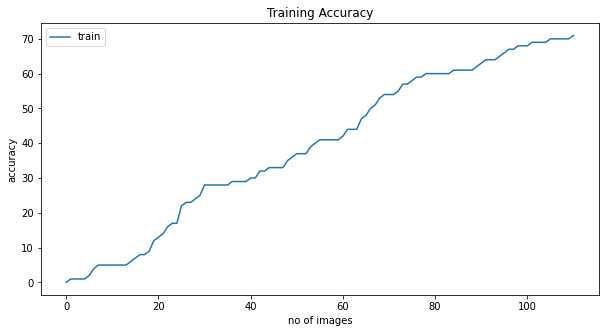

In [17]:
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(tr_accuracy,label="train")
plt.xlabel("no of images")
plt.ylabel("accuracy")
plt.legend()
plt.show()

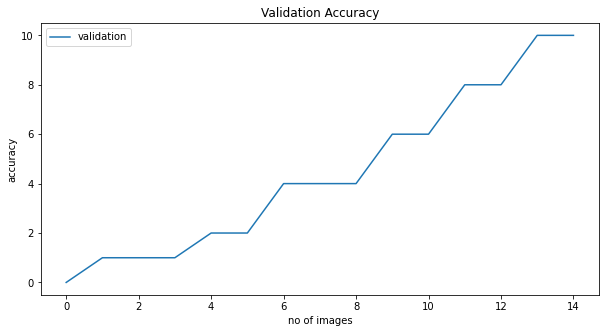

In [18]:
plt.figure(figsize=(10,5))
plt.title("Validation Accuracy")
plt.plot(val_accuracy,label="validation")
plt.xlabel("no of images")
plt.ylabel("accuracy")
plt.legend()
plt.show()

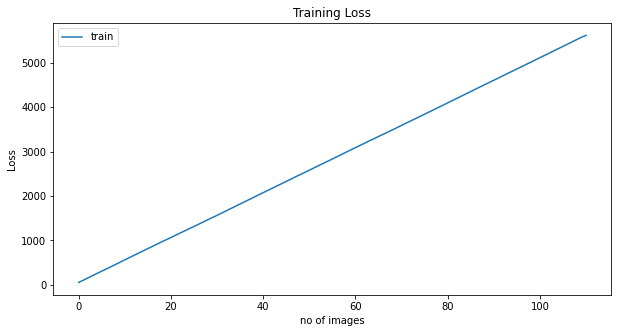

In [19]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("no of images")
plt.ylabel("Loss")
plt.legend()
plt.show()

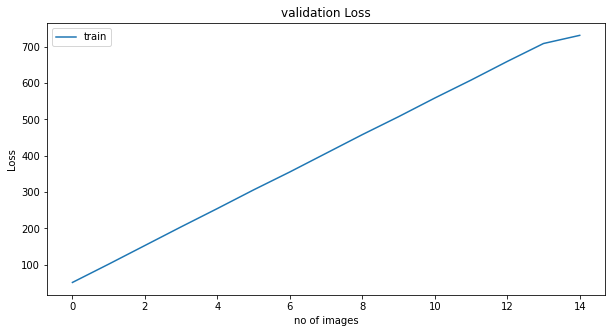

In [20]:
plt.figure(figsize=(10,5))
plt.title("validation Loss")
plt.plot(val_losses,label="train")
plt.xlabel("no of images")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
model=ConvNet(num_classes=23)
model.load_state_dict(torch.load(path))
model.eval()

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=4000, bias=True)
  (fc2): Linear(in_features=4000, out_features=4000, bias=True)
  (fc3): Linear(in_features=4000, out_features=23, bias=True)
  (softmax): Softmax(dim=1)
)

**Predicting few images from the test data set**

In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  chilli pepper ginger chilli pepper ginger
